# Simple regression with TensorFlow

Progressive example working through various network set ups

https://towardsdatascience.com/training-neural-networks-for-price-prediction-with-tensorflow-8aafe0c55198

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

In [24]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
tf.random.set_seed(42)


2.13.1


In [25]:
from keras import Sequential
from keras import models
from keras import layers

In [26]:
dat = pd.read_csv("./rbfs/phi_short_reduce.csv")
dat.head()
#X = np.load("./rbfs/phi_reduce.npy")
#y = np.load("./rbfs/y.npy")

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,194,195,196,197,198,199,200,y,site,date
0,0,1.000000,0.962154,0.856997,0.706648,0.539408,0.381171,0.249352,0.151007,0.084658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014,2005,2023-01-01
1,1,0.999972,0.964124,0.860533,0.711037,0.543884,0.385132,0.252466,0.153209,0.086071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007,2005,2023-01-01
2,2,0.999889,0.966044,0.864036,0.715413,0.548366,0.389112,0.255604,0.155436,0.087503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,2005,2023-01-01
3,3,0.999749,0.967914,0.867505,0.719775,0.552855,0.393111,0.258767,0.157686,0.088954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009,2005,2023-01-01
4,4,0.999555,0.969734,0.870939,0.724124,0.557350,0.397130,0.261955,0.159960,0.090424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011,2005,2023-01-01


In [27]:
dat.site

0       2005
1       2005
2       2005
3       2005
4       2005
        ... 
2664    4002
2665    4002
2666    4002
2667    4002
2668    4002
Name: site, Length: 2669, dtype: int64

In [28]:
dat2 = dat[dat['date'] == "2023-01-01"]
dat2.shape

(191, 205)

In [29]:
dat2 = dat2.groupby('site')

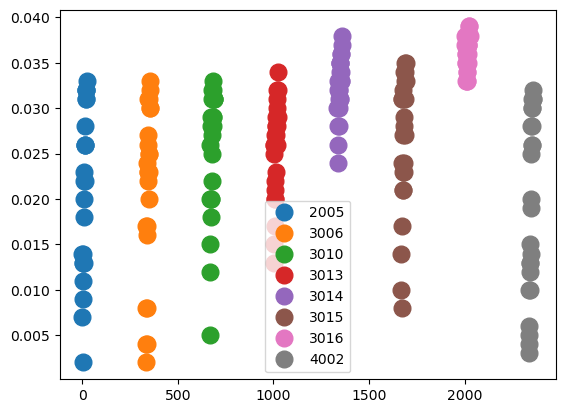

In [30]:
# Plot
fig, ax = plt.subplots()

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in dat2:
    ax.plot(group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [31]:
X = dat.iloc[:, 1:202]
y = dat['y']

In [32]:
groups = dat['site']
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

8

In [33]:
groups

0       2005
1       2005
2       2005
3       2005
4       2005
        ... 
2664    4002
2665    4002
2666    4002
2667    4002
2668    4002
Name: site, Length: 2669, dtype: int64

In [34]:
mygrps = groups.unique()
n_grps = len(mygrps)

In [35]:
def make_model(n_feat):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(n_feat,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='linear')
        ], name="Initial_model")
    return model

In [36]:
model = make_model(100)
model.summary()

Model: "Initial_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 512)               51712     
                                                                 
 dense_55 (Dense)            (None, 512)               262656    
                                                                 
 dense_56 (Dense)            (None, 256)               131328    
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                                                 
 dense_58 (Dense)            (None, 128)               32896     
                                                                 
 dense_59 (Dense)            (None, 1)                 129       
                                                                 
Total params: 544513 (2.08 MB)
Trainable params: 5445

## Cross-validation loop

In [37]:
# Model set up
initial_learning_rate = 0.00001
optimizer = keras.optimizers.legacy.Adam(learning_rate=initial_learning_rate)
n_epochs = 20
batch_size = 1024

In [38]:
my_mae = np.empty(n_grps)
my_y_true = []
my_y_pred = []

In [39]:
for i, (train_index, test_index) in enumerate(logo.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"Site {mygrps[i]}:")
    #print(f"  Train: index={train_index}, group={groups[train_index]}")
    #print(f"  Test:  index={test_index}, group={groups[test_index]}")

    # Split out data
    X_train = X.iloc[train_index, :]
    print(X_train.shape)
    y_train = y[train_index]
    n_feat = X_train.shape[1]
    
    X_test = X.iloc[test_index, :]
    print(X_test.shape)
    y_test = y[test_index]

    # Build model
    model = make_model(n_feat)

    # Compile model
    model.compile(loss='mae', metrics=['mae', 'mse'], optimizer=optimizer)

    # Train model
    history=model.fit(X_train, y_train, epochs=n_epochs, 
                  batch_size=batch_size, verbose=1, 
                  validation_split=0.2)
    
    ## Predict for test set
    y_test_pred = model.predict(X_test)
    my_mae[i] = mean_absolute_error(y_test, y_test_pred)
    print(f"MAE: {my_mae[i]}")
    
    my_y_true.append(y_test.to_numpy())
    my_y_pred.append(y_test_pred)




Fold 0:
Site 2005:
(2336, 201)
(333, 201)
Epoch 1/20
2/2 [==============================] - 0s 91ms/step - loss: 0.0505 - mae: 0.0505 - mse: 0.0038 - val_loss: 0.0331 - val_mae: 0.0331 - val_mse: 0.0015
Epoch 2/20
2/2 [==============================] - 0s 29ms/step - loss: 0.0438 - mae: 0.0438 - mse: 0.0029 - val_loss: 0.0270 - val_mae: 0.0270 - val_mse: 0.0011
Epoch 3/20
2/2 [==============================] - 0s 27ms/step - loss: 0.0380 - mae: 0.0380 - mse: 0.0022 - val_loss: 0.0227 - val_mae: 0.0227 - val_mse: 8.0394e-04
Epoch 4/20
2/2 [==============================] - 0s 30ms/step - loss: 0.0331 - mae: 0.0331 - mse: 0.0017 - val_loss: 0.0202 - val_mae: 0.0202 - val_mse: 6.4400e-04
Epoch 5/20
2/2 [==============================] - 0s 31ms/step - loss: 0.0290 - mae: 0.0290 - mse: 0.0013 - val_loss: 0.0187 - val_mae: 0.0187 - val_mse: 5.6614e-04
Epoch 6/20
2/2 [==============================] - 0s 30ms/step - loss: 0.0255 - mae: 0.0255 - mse: 0.0011 - val_loss: 0.0185 - val_mae: 0.018

In [40]:
my_y_pred

[array([[0.02473607],
        [0.02576819],
        [0.02667796],
        [0.02784793],
        [0.02902524],
        [0.03008779],
        [0.03112842],
        [0.03238557],
        [0.03357401],
        [0.03479438],
        [0.03609812],
        [0.0375376 ],
        [0.03912792],
        [0.04042957],
        [0.0416574 ],
        [0.0427372 ],
        [0.04352731],
        [0.04417036],
        [0.04488124],
        [0.04557502],
        [0.0463943 ],
        [0.04730592],
        [0.04831234],
        [0.04929835],
        [0.05007092],
        [0.05079196],
        [0.05140917],
        [0.05182942],
        [0.05212934],
        [0.05229283],
        [0.05226826],
        [0.05225939],
        [0.05229965],
        [0.05235715],
        [0.05214418],
        [0.05134628],
        [0.05058048],
        [0.04986135],
        [0.048619  ],
        [0.04718797],
        [0.04560966],
        [0.04379625],
        [0.04191815],
        [0.03984421],
        [0.0381037 ],
        [0

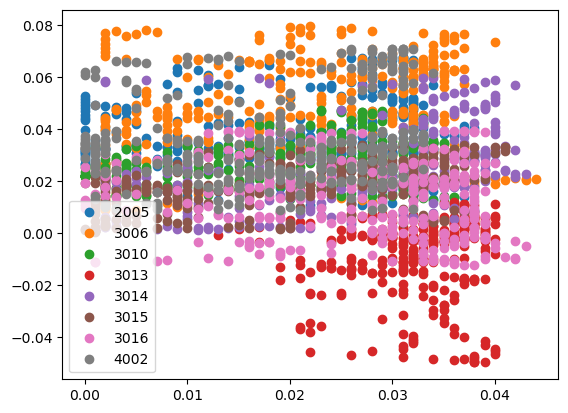

In [41]:
plt.figure()
for i in range(len(mygrps)):
    plt.plot(my_y_true[i], my_y_pred[i], 'o', label = mygrps[i])

plt.legend()
plt.show()

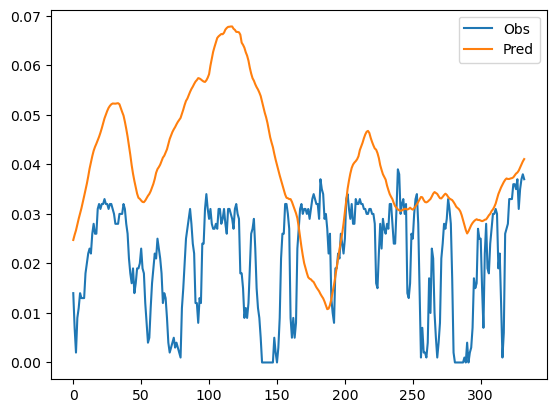

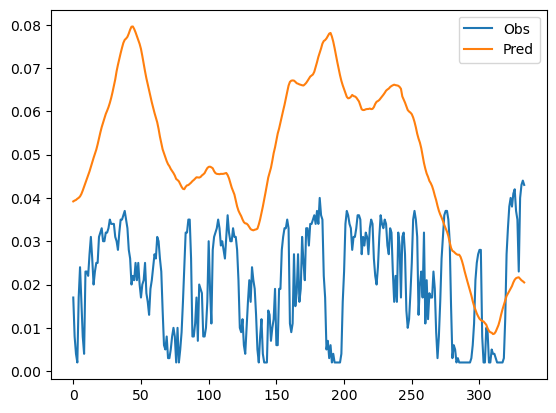

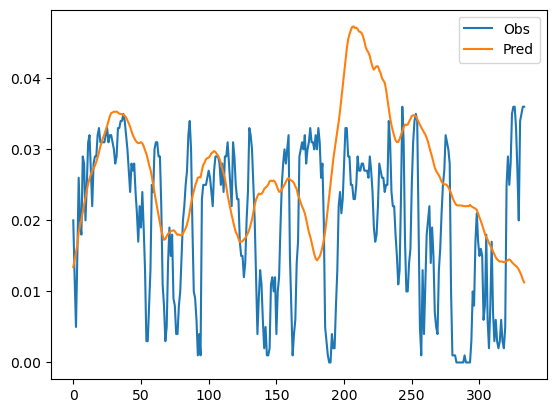

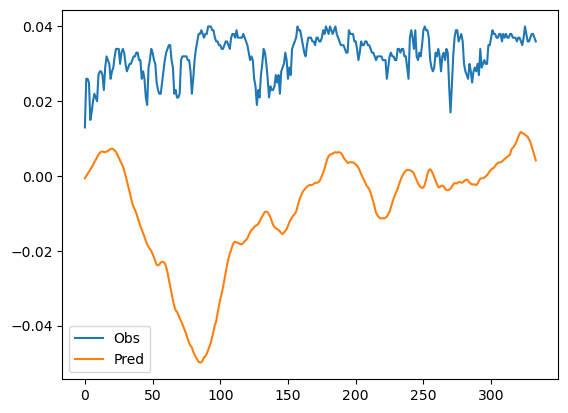

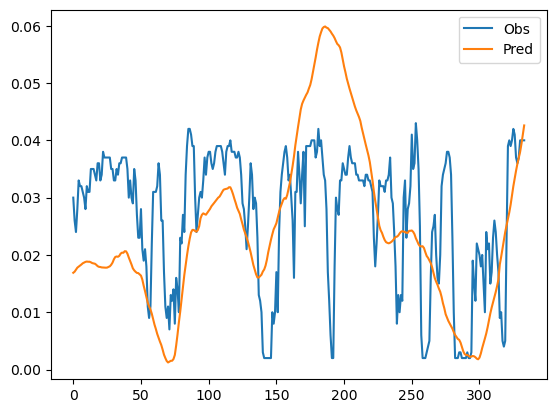

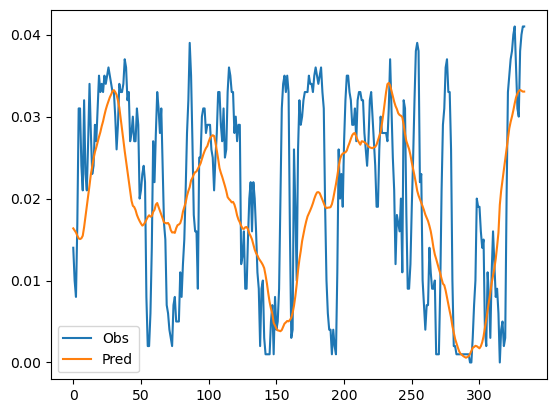

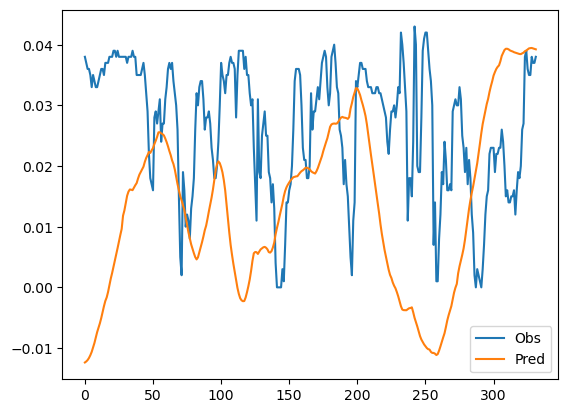

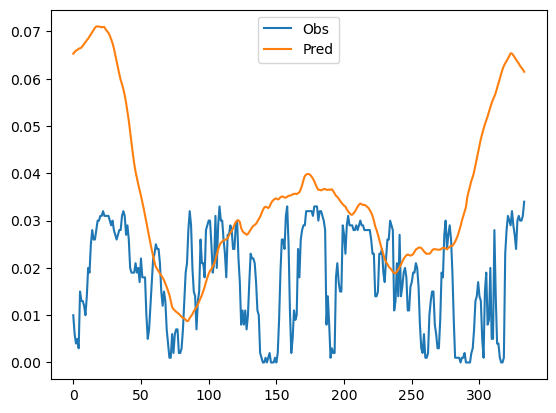

In [42]:
for i in range(len(mygrps)):
    plt.plot(my_y_true[i], label = "Obs")
    plt.plot(my_y_pred[i], label = "Pred")
    plt.legend()
    plt.show()